We aim to use `RADAR` to do differential analysis of m6A peaks. I'm starting from `fastq` raw data to align them using `STAR`; then I will use `bam` files to run `RADAR` and explore the results for downstream analysis.

I needed to re-build `STAR` indices as I've described in my notebook at `genomes/build-genome.ipynb` (see my GitHub repo). 

# Alignment task - Running `STAR`

In [10]:
pwd

'/data_gilbert/home/aarab/Projects/Decitabine-treatment/DAC/meRIP-seq'

In [7]:
cat star.sh

index=$1
bamDIR=$2

mkdir -p ${bamDIR}
mkdir -p ${bamDIR}_star_qc

STAR --genomeLoad LoadAndExit --genomeDir $index

for fq in fastq/*R1*; do
    fq=`basename $fq`
    out=${fq/_R1*/}
    echo '------------' $out '-----------'
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 18 \
    --genomeDir $index \
    --readFilesIn fastq/$fq \
    --outFileNamePrefix ${bamDIR}/$out
done

STAR --genomeLoad Remove --genomeDir $index

rm -vr _STARtmp/ Aligned.out.sam Log.out Log.progress.out


In [2]:
!which STAR

/data_gilbert/home/aarab/anaconda3/envs/alignment/bin/STAR


In [8]:
ls ../../herv-genome/STAR.index/

chrLength.txt      exonInfo.tab          SAindex
chrNameLength.txt  geneInfo.tab          sjdbInfo.txt
chrName.txt        Genome                sjdbList.fromGTF.out.tab
chrStart.txt       genomeParameters.txt  sjdbList.out.tab
exonGeTrInfo.tab   SA                    transcriptInfo.tab


In [9]:
!bash star.sh ../../herv-genome/STAR.index/ bam_erv

Nov 14 12:19:45 ..... started STAR run
Nov 14 12:19:45 ..... loading genome
------------ T1.input -----------
Nov 14 12:20:13 ..... started STAR run
Nov 14 12:20:13 ..... loading genome
Nov 14 12:20:35 ..... started mapping
Nov 14 12:22:35 ..... finished mapping
Nov 14 12:22:41 ..... started sorting BAM
Nov 14 12:23:47 ..... finished successfully
------------ T1.m6A -----------
Nov 14 12:23:54 ..... started STAR run
Nov 14 12:23:54 ..... loading genome
Nov 14 12:24:15 ..... started mapping
Nov 14 12:25:56 ..... finished mapping
Nov 14 12:26:01 ..... started sorting BAM
Nov 14 12:26:28 ..... finished successfully
------------ T2.input -----------
Nov 14 12:26:31 ..... started STAR run
Nov 14 12:26:31 ..... loading genome
Nov 14 12:26:52 ..... started mapping
Nov 14 12:28:51 ..... finished mapping
Nov 14 12:28:56 ..... started sorting BAM
Nov 14 12:29:57 ..... finished successfully
------------ T2.m6A -----------
Nov 14 12:30:04 ..... started STAR run
Nov 14 12:30:04 ..... loading genome

# Peak calling task - Running `RADAR`

https://scottzijiezhang.github.io/RADARmanual/workflow.html

In [2]:
!mkdir radar_erv

In [ ]:
# %load_ext rpy2.ipython

In [1]:
# %%R 
suppressMessages(suppressWarnings(library (RADAR)))

In [ ]:
GTF = '../../herv-genome/package-entities-erv.c.gff3'

### 1. load `bam` files and make `MeRIP.RADAR` object
I'll save the object for later usage while it takes long time to generate. 

In [7]:
# %%R 
radar <- countReads(
	samplenames=c('U1','U2','T1','T2'), gtf = GTF,
	bamFolder='./bam_scallop/',modification = "m6A", 
    strandToKeep = "opposite",
    outputDir='radar_scallop', 
    threads = 30
) 

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 30 thread(s) to count reads in continuous bins...
Time used to count reads: 22.7265259464582 mins... 


In [8]:
# %%R 
saveRDS(radar, 'radar_scallop/rawObj.rds')

In [9]:
# %%R 
summary(radar)

MeRIP dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         U1    U2    T1    T2
Input 22.36 27.48 24.09 21.92
IP    34.95 33.21 39.47 40.76


___

### 2. Running RADAR pre processing commands 
https://scottzijiezhang.github.io/RADARmanual/Mannual.html

Final object after this step also saved into `radar/finalObj.rds`.

In [ ]:
# %reload_ext rpy2.ipython

In [1]:
# %%R 
suppressMessages(suppressWarnings(library (RADAR)))

In [2]:
radar0 <- readRDS('radar_scallop/rawObj.rds')

In [3]:
radar0 <- normalizeLibrary(radar0, boxPlot=0)

In [4]:
radar0 <- adjustExprLevel(radar0)
# radar <- adjustExprLevel(radar, adjustBy = "pos")

# If you expect intensive alternative splicing events cross the experimental groups, 
# using gene-level read counts to represent pre-IP RNA level could leads to bias. 
# Therefore, the user can also choose to use the local bin-level read count to adjust 
# the pre-IP RNA level variation

variable(radar0) <- data.frame( group = c(rep("Untreated",2),rep("Treated",2)))

Adjusting expression level using Input geneSum read count...


In [6]:
radar0 <- filterBins(radar0,minCountsCutOff = 0)

radar0 <- diffIP_parallel(radar0,thread = 30)
saveRDS(radar0, 'radar_scallop/finalObj.rds')

Filtering bins with low read counts...
Bins with average counts lower than  0  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
Untreated Untreated   Treated   Treated 
        0         0         1         1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 30 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.690665825208028 mins... 



### 4. Get results and select significant bins

Results for all data (no filtering):

In [7]:
# %%R 
# radar0 <- readRDS('radar_scallop/finalObj.rds')

In [8]:
radar_all <- reportResult(radar0, cutoff = 1.1, Beta_cutoff = 0.00, threads=18)

result_all <- results(radar_all)
rm(radar0)

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 4.03426253795624 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 41029 reported differential loci at FDR < 1.1 and logFoldChange > 0.


> Due to the resolution of the MeRIP-seq experiment where RNA molecules are fragmented into 100-300nt, neighboring bins can usually contain reads from the same locus. Therefore, we do a post-processing to merge significant neighboring bins after the test to obtain a final list of differential peaks. We merge the p-value of connecting bins by fisher’s method and report the max beta from neighbouring bins.

Here, we use FDR<0.1 and log fold change > 0.5 as default cutoff for selecting significant bins

In [9]:
radar0 <- readRDS('radar_scallop/finalObj.rds')

In [10]:
radar_sig <- reportResult(radar0, cutoff = 0.10, Beta_cutoff = 0.5, threads=18)

result_sig = results(radar_sig) 
rm(radar0)

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.579263540108999 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 4253 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


### 5. Plots
#### Pre processing plots

Below command normalize the library and make box plots. I'll save the plots into files.

In [ ]:
# %%R
# ## save pictures 
# pdf('radar_scallop/plots/boxPlot.pdf')
# radar <- normalizeLibrary(radar0)
# dev.off()
# png('plots/boxPlot.png')
# radar <- normalizeLibrary(radar0)
# dev.off()

In [12]:
summary(radar_sig)

MeRIP.RADAR dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         U1    U2    T1    T2
Input 22.36 27.48 24.09 21.92
IP    34.95 33.21 39.47 40.76
Input gene level read count available.
There are 1 predictor variables/covariates. Can access by function variable(MeRIPdata). 
Differential methylation tested by PoissonGamma test (RADAR).
Multiple test corrected by Benjamini & Hochberg.
Neighboring significant bins merged. There are 4253 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


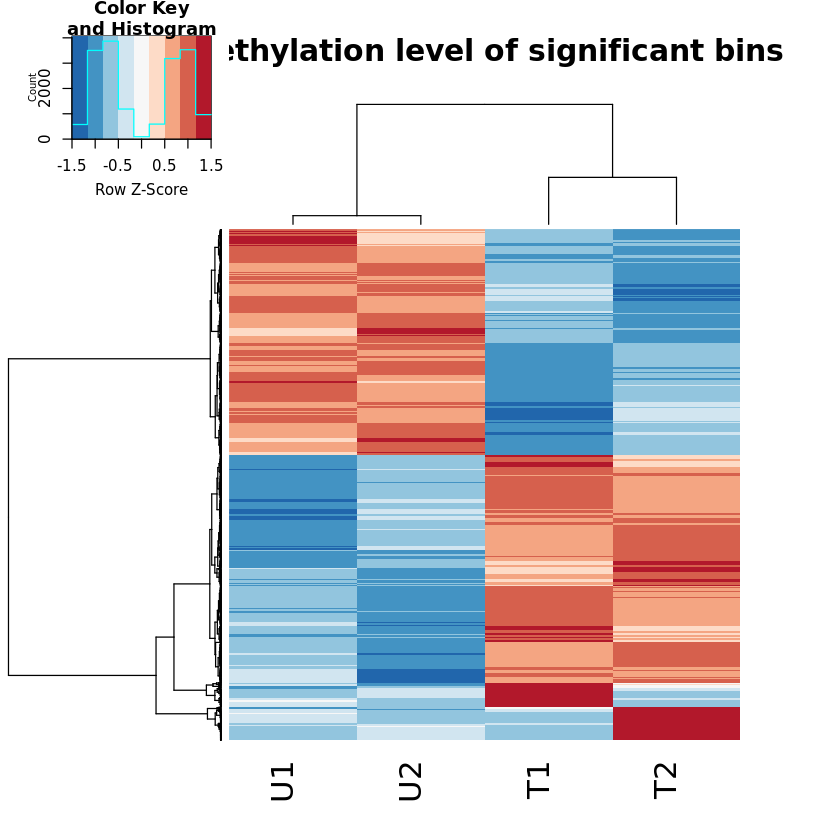

In [13]:
# %%R 
plotHeatMap(radar_sig)

In [ ]:
# %%R 
peakDistribution(radar_sig)

___
## Save results into files

In [14]:
# %%R 
suppressMessages(suppressWarnings(library (tidyverse)))

In [17]:
GTF

[1] "../scallop-genome/DAC_GRCh37_merged.gtf"

In [18]:
# %%R 
gtf <- rtracklayer::import(GTF)

# gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')
# message ('-> GTF loaded!')

# add_Name <- function(res, gene2name){
#     res$ensembl <- res$name %>% as.character
#     res$name <- gene2name[res$ensembl %>% as.character,]
#     return (res)
# }

In [22]:
result_sig %>% filter(grepl('DAC',name))

chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<dbl>,<dbl>
chr1,85724299,85724348,DAC.12-x1-0,0,-,85724299,85724348,0,1,49,0,2.944439,1.912371e-03
chr13,27787083,27787132,DAC.252-x1-0,0,+,27787083,27787132,0,1,49,0,4.382027,2.465841e-05


In [23]:
result_all %>% filter(grepl('DAC',name))

chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<dbl>,<dbl>
chr1,85718382,85724348,DAC.12-x1-0,0,-,85718382,85724348,0,2,"4,142","0,5825",-5.4847969,0.01058394
chr9,74586481,74587648,DAC.204-x1-0,0,+,74586481,74587648,0,2,"54,41","0,1127",-3.9512437,0.12382754
chr11,65306434,65306483,DAC.222-x1-0,0,-,65306434,65306483,0,1,49,0,-2.1897896,0.45291340
chr11,110171043,110171092,DAC.223-x1-0,0,-,110171043,110171092,0,1,49,0,-1.3862944,0.28816489
chr12,1192345,1192689,DAC.230-x1-0,0,+,1192345,1192689,0,1,344,0,0.8758617,0.04156374
chr12,1213957,1219422,DAC.230-x1-0,0,+,1213957,1219422,0,2,"34,65","0,5401",0.6127657,0.81236235
chr12,1250787,1250885,DAC.230-x1-0,0,+,1250787,1250885,0,1,98,0,-5.5947114,0.05141639
chr13,27787083,27787319,DAC.252-x1-0,0,+,27787083,27787319,0,1,236,0,4.3820266,0.00315255
chr13,27793507,27793556,DAC.252-x1-0,0,+,27793507,27793556,0,1,49,0,0.4700036,0.72965087


In [24]:
# %%R
write.table(result_all %>% filter(grepl('DAC',name)), file = "radar_scallop/result.all.txt",row.names=F, sep='\t', quote=FALSE) 
write.table(result_sig %>% filter(grepl('DAC',name)), file = "radar_scallop/result.sig.txt",row.names=F, sep='\t',quote=FALSE) 

In [ ]:
# cp -v radar/result.sig.txt hl60_delta_mtyl_table.txt 

In [ ]:
# !cat hl60_delta_mtyl_table.txt | head 

### Save results into `bed12` format 
`tidyverse` can not be loaded while using RADAR!

In [26]:
# save bed 12 format 
names(result_all)[1] <- paste0("# ", names(result_all)[1])
write.table(result_all %>% dplyr::select(c(1:12)) %>% filter(grepl('DAC',name)), file = "radar_scallop/result.all.bed",row.names=F, sep="\t", quote=FALSE) 

Warning message:
“`lang()` is deprecated as of rlang 0.2.0.
Please use `call2()` instead.
This warning is displayed once per session.”
Warning message:
“`new_overscope()` is deprecated as of rlang 0.2.0.
Please use `new_data_mask()` instead.
This warning is displayed once per session.”
Warning message:
“`overscope_eval_next()` is deprecated as of rlang 0.2.0.
Please use `eval_tidy()` with a data mask instead.
This warning is displayed once per session.”


In [27]:
# save bed 12 format 
names(result_sig)[1] <- paste0("# ", names(result_sig)[1])
write.table(result_sig %>% dplyr::select(c(1:12)) %>% filter(grepl('DAC',name)), file = "radar/result.sig.bed",row.names=F, sep='\t',quote=FALSE)

In [29]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/imRIP/radar/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] bindrcpp_0.2.2            forcats_0.3.0            
 [3] stringr_1.3.1             dplyr_0.7.6              
 [5] purrr_0.2.5               readr_1.1.1              
 [7] tidyr_0.8.1               tibble_1.4.2             
 [9] tidyverse_1.2.1           RADAR_0.2.3    

In [30]:
date()

[1] "Tue Aug 30 22:10:03 2022"